# Social Network Analysis - Community Detection
This notebook delves deeper into several community detection approaches, which can be applied on social network data consisting of vertices and edges.
In particular, it covers traditional approaches such as the Greedy Modularity Algorithm, the Louvian Algorithm as well as machine learning algorithms
such as DBScan.

# Hypothesis: Relationship between Betweenness  and Communities

**Background**: The betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v.

**Notion of Participation Coefficient**

Participation coefficients measure the distribution of a node’s edges among the communities of a graph.
If a node’s edges are entirely restricted to its community, its participation coefficient is 0.

**Formula of the Participation Coefficient**:

The Participation Coefficient $( P_i $) for a node $( i $) is defined as:

$P_i = 1 - \sum_{c=1}^{C} \left( \frac{k_{i,c}}{k_i} \right)^2$

Where:
- $( C $) is the total number of communities in the graph.
- $( k_{i,c} $) is the number of edges node \( i \) has with nodes in community \( c \).
- $( k_i $) is the total degree of node \( i \), i.e., the total number of edges connected to node \( i \).

**Hypothesis**: We assume that users with a high betweenness centrality have a higher participation coefficient. The reason for this assumption is that
users with high betweenness centrality might serve as key intermediaries between different communities in a network by bridging structural gaps.
Consequently, users with a high betweenness centrality have more connection to other communities than random nodes.

**Evaluation**: To evaluate this hypothesis we will measure the linear relationship between the betweenness centrality and the
participation coefficient of each node. To fully verify this hypothesis other statistical tests might be helpful.


**Sources**:

- https://pmc.ncbi.nlm.nih.gov/articles/PMC3838673/#:~:text=Participation%20coefficients%20measure%20the%20distribution,its%20participation%20coefficient%20is%200
- https://pmc.ncbi.nlm.nih.gov/articles/PMC7286311/#:~:text=Normalized%20Participation%20Coefficient%20(PCnorm)&text=Formally%2C%20the%20PC%20of%20node,nodes%20in%20the%20entire%20network.

# Approach
1. Load the data
   1. Imports
   2. Loading the network
2. Community Detection with NetworkX
   1. Louvain Algorithm
   2. Greedy Modularity Algorithm
3. Community Detection with DBScan
   1. Vectorization with Node2Vec
   2. Dimensionality Reduction
   3. DBScan
4. Evaluation of Community Detection
5. Visualization
6. Evaluating the Hypothesis

# 1. Load the Data

##  1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from networkx.algorithms.community import (
    louvain_communities,
    greedy_modularity_communities,
    modularity,
)
from node2vec import (
    Node2Vec,
)
from gensim.models import (
    Word2Vec,
)
from igraph import (
    Graph,
    plot,
)
from sklearn.manifold import (
    TSNE,
)
import matplotlib.pyplot as plt
from sklearn.neighbors import (
    NearestNeighbors,
)
from sklearn.cluster import (
    DBSCAN,
)
from sklearn.metrics import (
    silhouette_score,
)
from sklearn.decomposition import (
    TruncatedSVD,
)

/Users/marcsutjipto/Library/Caches/pypoetry/virtualenvs/social-network-analysis-da1-5gboGs_D-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2 Loading the Network

In [2]:
# Load the CSV-Files and store it as pandas dataframe
df_network = pd.read_csv(
    "../data/graph.csv",
    delimiter=",",
)
df_network.head()

,source,target,weight
0,1084949174,1050463558,1
1,1084949174,1002148361,1
2,1084949174,1000741574,1
3,1084949174,1019020642,1
4,1084949174,1044910984,1


In [3]:
# Convert the df_network dataframe into a networkx graph object
x_network = nx.from_pandas_edgelist(
    df_network,
    "source",
    "target",
)
print(x_network)

Graph with 46849 nodes and 94884 edges


In [4]:
# Convert network into an igraph object
# ATTENTION: IGraph will be mainly used to conduct tasks with a high computational complexity,
# since this library is implemented in C

igraph_graph = Graph.from_networkx(
    x_network
)
print(
    igraph_graph.summary()
)

IGRAPH U--- 46849 94884 -- 
+ attr: _nx_name (v)


In [7]:
# Plot the graph for a first visual impression

# Let IGraph determine the best fitting layout
layout = igraph_graph.layout(
    "auto"
)

# A stored figure can be found in the directory ../docs/standard_network.png.
# ATTENTION: The figure is not displayed here since it would consume too much space in the notebook.
plot(
    igraph_graph,
    layout=layout,
    vertex_size=5,
    edge_width=0.1,
    vertex_label_dist=0.5,
    bbox=(500, 500),
)

**Visual Impression**: Above it is already visible that many nodes are overlapping, which looks like there are many small communities of nodes.
Furthermore, it looks like there is a bigger community in the center of the network.

# 2. Community Detection with NetworkX
The NetworkX library offers several approaches to detect communities in a social network. <br>
In this section we will examine the Louvain Algorithm as well as the Greedy Modularity Algorithm. <br>

## 2.1 Louvain Algorithm


The **Louvain algorithm** is an efficient **community detection** method that maximizes **modularity** in a network. It works iteratively in two phases:

1. **Local Optimization**: Each node is temporarily assigned to a community to improve modularity.
2. **Community Aggregation**: The detected communities are treated as super-nodes, and the process is repeated.

This approach is highly efficient for large networks and often produces well-structured community partitions.

In [7]:
# Assign each user to a community with the louvain_communities function
communities_louvain = louvain_communities(
    x_network,
    seed=42,
)

# Print the number of communities for the louvain algorithm
print(
    len(
        communities_louvain
    )
)

245


## 2.2 Greedy Modularity Algorithm
The **Greedy Modularity Algorithm** follows a hierarchical, agglomerative approach:

1. Each node starts as its own community.
2. Iteratively, communities are merged to maximize modularity gain.
3. The process stops when no further modularity improvement is possible.

In [9]:
# Assign each user to a community with the louvain_communities function
communities_greedy = greedy_modularity_communities(
    x_network,
)

# Print the number of communities for the louvain algorithm
print(
    len(
        communities_greedy
    )
)

307


# 3. Community Detection with KMeans and DBScan
This section examines two clustering methods introduced in class.
Both methods use a numerical vector as input parameter. Consequently, it is necessary
to convert the graph representation of the network into a numerical representation.
A popular method to convert a graph into a numerical vector is the Node2Vec Algorithm.

Source for the Node2Vec approach: <br>
**Grover, A., & Leskovec, J. (2016, August). node2vec: Scalable feature learning for networks. In Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 855-864).**


## 3.1 Vectorization with Node2Vec

In [8]:
# Create Node2Vec Object
# Adapt the number of workers = 1, if you use Windows!
node2vec = Node2Vec(
    x_network,
    dimensions=128,
    walk_length=80,
    num_walks=80,
    p=2,
    q=0.5,
    workers=4,
)

Generating walks (CPU: 4): 100%|██████████| 20/20 [03:00<00:00,  9.04s/it]


In [10]:
# Create embeddings for the network nodes
# model = node2vec.fit(window=10,
#                     min_count=1,
#                     batch_words=100)

# Alternative: Load stored model from models directory
model = Word2Vec.load(
    "../models/embeddings_n2v.model"
)

In [11]:
# Store embeddings and user_ids
node_ids = list(
    model.wv.index_to_key
)
embeddings = np.array(
    [
        model.wv[
            node
        ]
        for node in node_ids
    ]
)

## 3.2 Dimensionality Reduction
In order to reduce the computational complexity the dimensions of the embeddings will be reduced with a dimensionality reduction approach.
For visualization purposes the t-SNE Algorithm will be used. To keep as much characteristics in the data as possible the SVD approach will be used.

### 3.2.1 TSNE with Visualization

In [12]:
# Reduce to two components
tsne = TSNE(
    n_components=2,
    random_state=42,
)
embeddings_2d = tsne.fit_transform(
    embeddings
)

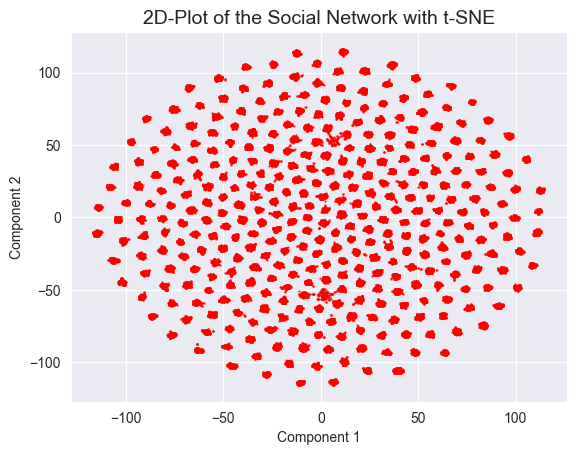

In [13]:
# Plot the Network in a 2D-representation
plt.scatter(
    embeddings_2d[
        :, 0
    ],
    embeddings_2d[
        :, 1
    ],
    s=0.5,
    alpha=0.7,
    c="red",
)

plt.title(
    "2D-Plot of the Social Network with t-SNE",
    fontsize=14,
)
plt.xlabel(
    "Component 1"
)
plt.ylabel(
    "Component 2"
)
plt.show()

**Observation**: Compared with the standard graph from IGraph (see ../docs/standard_network.png) the 2D representation looks very similar,
 since nodes overlap with each other and form small communities. Even the visual representation looks similar.

### 3.2.2 Dimensionality Reduction with the TruncatedSVD approach
In order check how many dimensions keep the most variance in the embeddings, we need to determine how much variance is kept by each component.
We can check this by creating a cumulative variance plot based on all dimensions n=128.

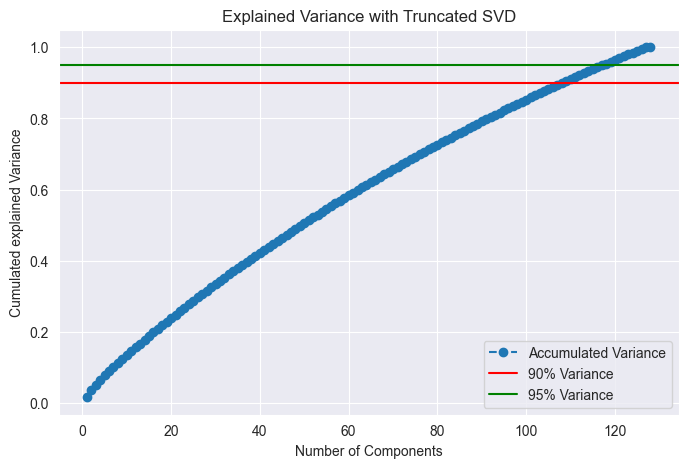

In [30]:
# Define number of components and SVD object
n_components = 128
svd = TruncatedSVD(
    n_components=n_components
)

# Dimensionality reduction
svd.fit(embeddings)

# Calculate explained variance ratio and cumulative variance
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(
    explained_variance_ratio
)

# Create the plot
plt.figure(
    figsize=(8, 5)
)
plt.plot(
    range(
        1,
        n_components
        + 1,
    ),
    cumulative_variance,
    marker="o",
    linestyle="--",
    label="Accumulated Variance",
)
plt.axhline(
    y=0.90,
    color="r",
    linestyle="-",
    label="90% Variance",
)
plt.axhline(
    y=0.95,
    color="g",
    linestyle="-",
    label="95% Variance",
)

plt.xlabel(
    "Number of Components"
)
plt.ylabel(
    "Cumulated explained Variance"
)
plt.title(
    "Explained Variance with Truncated SVD"
)
plt.legend()
plt.grid(True)
plt.show()

**Observation**: It seems that around 100 hundred components are necessary to cover 90% of the variance in the data.
Hence, dimensionality reduction can not be applied to a low number of dimensions without losing much information in the data.
Therefore,  the usage of KMeans makes not much sense, due to the curse of dimensionality for the euclidean distance function.
As a consequence we will use the DBScan algorithm with the cosine distance metric for dommunity detection.

## 3.3 DBScan
To determine an optimal value for the eps parameter, we will create a k-distance plot.

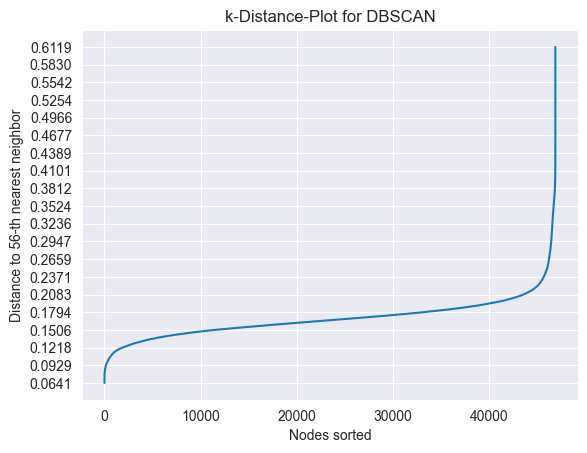

In [21]:

min_samples = 56

nearest_neighbors = NearestNeighbors(
    n_neighbors=min_samples,
    metric="cosine",
)
nearest_neighbors.fit(
    embeddings
)
(
    distances,
    indices,
) = nearest_neighbors.kneighbors(
    embeddings
)

distances = np.sort(
    distances[:, -1]
)
plt.plot(distances)
plt.xlabel(
    "Nodes sorted"
)
plt.ylabel(
    f"Distance to {min_samples}-th nearest neighbor"
)
plt.yticks(
    np.linspace(
        min(
            distances
        ),
        max(
            distances
        ),
        20,
    )
)
plt.title(
    "k-Distance-Plot for DBSCAN"
)
plt.grid(True)

**Observation**: The elbow on the right side of the plot, indicates an epsilon value of around **0,1348** as optimal.

In [12]:
# Create Cluster labels with DBScan
dbscan = DBSCAN(
    eps=0.1348,
    min_samples=56,
    metric="cosine",
).fit(embeddings)

In [13]:
print(
    max(
        dbscan.labels_
    )
)

348


DBScan identifies 348 communities

# 4. Evaluation
In this section we will evaluate the cluster quality based on the silhouette_score and on the modularity
(only for Louvain and Greedy Modularity).

## 4.1 Silhouette Score

In [14]:
silhouette_dbscan = silhouette_score(
    embeddings,
    dbscan.labels_,
    metric="cosine",
)
print(
    silhouette_dbscan
)

0.46371394


**Result**: The DBScam algorithm has a silhouette score of 0,46, which is "okay".

# 4.2 Modularity

Modularity $Q$ is defined as:

$$
Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \gamma \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)
$$

where:

- $m$ = Number of edges in the graph (or sum of edge weights)
- $A_{ij}$ = Entry in the **adjacency matrix** $A$ (1 if an edge exists, otherwise 0)
- $k_i$ = **Degree** of node $i$ (sum of edge weights)
- $\gamma$ = **Resolution parameter** (controls the size of detected communities)
- $\delta(c_i, c_j)$ = Indicator function (1 if nodes $i$ and $j$ belong to the same community, otherwise 0)

A **higher** $Q$ value indicates a **better** community partition. Typically, $Q$ ranges between **0 and 1**.

**Source**: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html



In [62]:
modularity_louvain = modularity(
    x_network,
    communities_louvain,
)
print(
    f"Communites detected by the Louvain Algorithm"
    f" has the following modularity: {modularity_louvain}"
)

Communites detected by the Louvain Algorithm has the following modularity: 0.9662857758624497


In [63]:
modularity_greedy_mod = modularity(
    x_network,
    communities_greedy,
)
print(
    f"Communites detected by the Greedy Algorithm "
    f"has the following modularity: {modularity_greedy_mod}"
)

Communites detected by the Greedy Algorithm has the following modularity: 0.9683642772144145


**Observation**: Both community detection algorithms perform very well with a modularity score greater than 0,96 indicating
                 <br> a good seperation of the network into communities

**General Results**: For community detection it is much less computing intensive to use approaches such as Louvain or Greedy Modularity compared to
                     popular machine learning techniques such as DBScan. In this example community detection worked much better and faster for the Louvain and
                     the Greedy Modularity approach. Nevertheless, the possibility to convert network data (vertices and edges) to a numerical representation
                     provides many possibilities for applying traditional machine learning approaches or combinations with generative language models (e.g Graph
                     Retrieve Augmented Generation with Neo4j).

# 5. Visualization

In [19]:
# Assign cluster_ids to every node for the louvain algorithm
cluster_id_list_louv = []
cluster_node_id_list_louv = []
for (
    cluster_id,
    community,
) in enumerate(
    communities_louvain
):
    for (
        node
    ) in community:
        cluster_node_id_list_louv.append(
            node
        )
        cluster_id_list_louv.append(
            cluster_id
        )

In [17]:
# Assign cluster_ids to every node for the greedy modularity algorithm
cluster_id_list_gred = []
cluster_node_id_list_gred = []
for (
    cluster_id,
    community,
) in enumerate(
    communities_greedy
):
    for (
        node
    ) in community:
        cluster_node_id_list_gred.append(
            node
        )
        cluster_id_list_gred.append(
            cluster_id
        )

In [ ]:
# Plot the louvain communities
colors_louv = [
    plt.cm.tab10(
        i % 10
    )
    for i in cluster_id_list_louv
]

# Assign each node a color according to their cluster
igraph_graph.vs[
    "color_louv"
] = colors_louv

layout = igraph_graph.layout(
    "auto"
)


plot(
    igraph_graph,
    layout=layout,
    vertex_size=5,
    vertex_color=igraph_graph.vs[
        "color_louv"
    ],
    edge_width=0.1,
    bbox=(
        1000,
        1000,
    ),
    target="../docs/louvain_visualization.png",
)

In [ ]:
# Plot the greedy modularity communities
colors_gred = [
    plt.cm.tab10(
        i % 10
    )
    for i in cluster_id_list_gred
]

# Assign each node a color according to their cluster
igraph_graph.vs[
    "color_gred"
] = colors_gred

layout = igraph_graph.layout(
    "auto"
)


plot(
    igraph_graph,
    layout=layout,
    vertex_size=5,
    vertex_color=igraph_graph.vs[
        "color_gred"
    ],
    edge_width=0.1,
    bbox=(
        1000,
        1000,
    ),
    target="../docs/greedy_mod_visualization.png",
)

In [ ]:
# Plot the dbscan communities
colors_db = [
    plt.cm.tab10(
        i % 10
    )
    for i in dbscan.labels_
]

# Assign each node a color according to their cluster
igraph_graph.vs[
    "color_db"
] = colors_db

layout = igraph_graph.layout(
    "auto"
)


plot(
    igraph_graph,
    layout=layout,
    vertex_size=5,
    vertex_color=igraph_graph.vs[
        "color_db"
    ],
    edge_width=0.1,
    bbox=(
        1000,
        1000,
    ),
    target="../docs/dbscan_com_visualization.png",
)

# 6. Evaluating the Hypothesis
In order to evaluate our hypothesis we need to calculate the participation coefficient for each node
based on the clustering from the previous steps. Therefore, we first need to define a function that covers this functionality.

In [26]:
def participation_coefficient(
    G: nx.Graph,
    partition: list,
) -> dict:
    # Convert list into a dictionary
    partition_dict = {
        node: i
        for i, community in enumerate(
            partition
        )
        for node in community
    }

    pc = {}
    for (
        node
    ) in G.nodes():
        # Degree of a node
        ki = G.degree(
            node
        )

        # If degree = 0 it has no neighbor connections
        if ki == 0:
            pc[
                node
            ] = 0.0
            continue

        # Count how often neighbors of the node are in corresponding communities
        comm_strength = {}
        for neighbor in G.neighbors(
            node
        ):
            comm = partition_dict[
                neighbor
            ]
            if (
                comm
                not in comm_strength
            ):
                comm_strength[
                    comm
                ] = 0
            comm_strength[
                comm
            ] += 1

        # Calculate the normalized partition coefficient based on the formula
        sum_sq = sum(
            (
                ki_comm
                / ki
            )
            ** 2
            for ki_comm in comm_strength.values()
        )
        pc[node] = (
            1
            - sum_sq
        )

    return pc

In [27]:
# Return PC-Values for the social network
pc_values = participation_coefficient(
    x_network,
    communities_louvain,
)

# Convert into a dataframe
df_pc = pd.DataFrame(
    list(
        pc_values.items()
    ),
    columns=[
        "user_id",
        "partition_coefficient",
    ],
)

In [15]:
# Read popularity metrics
df_centrality_metrics = pd.read_csv(
    "../data/nodes_popularity_metrics.csv",
    delimiter=",",
)

In [18]:
column_name = "betweeness_centrality"  # Name der Spalte anpassen
df_centrality_metrics_merged = df_centrality_metrics.merge(
    df_pc,
    on="user_id",
)

In [21]:
# Calculate correlation between betweenness and partition coefficient
df_centrality_metrics_merged[
    "betweeness_centrality"
].corr(
    df_centrality_metrics_merged[
        "partition_coefficient"
    ],
    method="pearson",
)

0.07744536058720665

**Result**: There is no linear relationship between the betweenness centrality and the partition coefficient